In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import matplotlib as mpl
import umap
import scipy
from gensim.models import Word2Vec
import os
import torch
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import silhouette_score
from collections import Counter
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings("ignore", module='umap')
warnings.filterwarnings("ignore", module='sklearn')
os.environ['OMP_NUM_THREADS'] = '16'

def purity_score(y_clust, y_class):
    """
    Compute the purity score given algorithmic cluster assignments and ground truth labels.
    
    Parameters:
    - y_clust: array-like of shape (n_samples,), predicted cluster labels from a clustering algorithm.
    - y_class: array-like of shape (n_samples,), ground truth class labels.
    
    Returns:
    - purity: float, the computed purity score.
    """
    # Convert inputs to numpy arrays (if they are not already)
    y_clust = np.asarray(y_clust)
    y_class = np.asarray(y_class)
    
    unique_clusters = np.unique(y_clust[np.where(y_class != -1) and np.where(y_clust != -1)])
    
    total_points = len(y_clust)
    sum_max = 0
    
    for cluster in unique_clusters:
        # Find the indices for the current cluster
        indices = np.where(y_clust == cluster)[0]
        true_labels = y_class[indices]
        
        label_counts = Counter(true_labels)
        most_common_count = label_counts.most_common(1)[0][1]
        sum_max += most_common_count
    
    purity = sum_max / len(y_clust[np.where((y_class != -1) & (y_clust != -1))])
    return purity

In [7]:
df1 = pd.read_csv('data/preprocessed_old_corenlp_ungrouped.csv')

# path for the new file
df2 = pd.read_csv('data/preprocessed_new_corenlp_ungrouped.csv')

df = df1

In [8]:
df

,WKO#,ATA_Code,PROBLEM,DATE,ATA_Code.1,ACTION,processed_problem,processed_action,cleaned_problem,cleaned_action
0,1112587,7200,ENGINE IDLE OVERRIDE KILLED ENGINE.,7/3/2012,7200,"A/C WAS RUN UP, SET IDLE SPEED, MIXTURE OK, NO...",engine idle override kill engine,aircraft run set idle speed mixture ok leak,engine idle override kill engine,aircraft run set idle speed mixture ok leak
1,1112587,7200,ENGINE IDLE OVERRIDE KILLED ENGINE.,7/2/2012,7200,REMOVED & REPLACED FUEL SERVO W/ OVERHAULED S/...,engine idle override kill engine,remove replace fuel servo overhaul serial number,engine idle override kill engine,remove replace fuel servo overhaul serial number
2,1112587,7200,ENGINE IDLE OVERRIDE KILLED ENGINE.,7/1/2012,7200,"TRIED TO ADJUST IDLE SEVERAL TIMES, WOULDN'T A...",engine idle override kill engine,try adjust idle time adjust,engine idle override kill engine,try adjust idle time not adjust
3,1112599,7200,HAD ENGINE CHOKE & BRIEFLY LOSE POWER ON DEPAR...,7/2/2012,7200,"PERFORMED ENGINE RUN UP, FOUND CYL 2 LOWER PLU...",engine choke briefly lose power departure thr,perform engine run find cylinder lower plug foul,engine choke briefly lose power departure thr,perform engine run find cylinder lower plug fo...
4,1112600,7230,#2 & 4 CYL ROCKER COVER GASKETS ARE LEAKING.,7/2/2012,7230,REMOVED & REPLACED GASKETS.,cylinder rocker cover gasket leak,remove replace gasket,cylinder rocker cover gasket leak,remove replace gasket
...,...,...,...,...,...,...,...,...,...,...
6164,1162758,7200,FOD ON SIDE BATTERY CASE (ZIP TIE TAPED TO SIDE),4/6/2017,7200,REMOVED FOD,foreign object damage battery case zip tie tape,remove foreign object damage,foreign object damage battery case zip tie tape,remove foreign object damage
6165,1163094,7210,BOLT FOR ALT SUPPORT NEEDS SAFETY WIRE.,4/19/2017,7210,SAFETIED BOLT.,bolt alternator support need safety wire,safetied bolt,bolt alternator support need safety wire,safetied bolt
6166,1163224,520,AIR BOX GASKET REPLACEMENT.,4/24/2017,7200,N/A BY A/C MFG DATE.,air box gasket replacement,na aircraft manufacturing date,airbox gasket replace,na aircraft manufacturing date
6167,1163537,7200,R/H ENGINE #1 CYL EXHAUST ROCKER WORN ON SHAFT.,5/4/2017,7200,REPLACED W/ NEW ROCKER & ROCKER SHAFT. TAPPET ...,right engine cylinder exhaust rocker wear shaft,replace new rocker rocker shaft tappet clearance,right engine cylinder exhaust rocker wear shaft,replace new rocker rocker shaft tappet clearance


In [9]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic CUDA ops
    torch.backends.cudnn.benchmark = False     # Disable optimization for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)   # For hash-based operations

set_seed(21)

In [115]:
def gen_embeddings(text_col, method='bow'):
    embeddings = None
    if method == 'bow':
        cv = CountVectorizer()
        embeddings = cv.fit_transform(text_col)
    elif method == 'tfidf':
        tfidf = TfidfVectorizer(use_idf=True, norm='l2', sublinear_tf=False, max_df=0.99, min_df=0.0)
        embeddings = tfidf.fit_transform(text_col)
    elif method == 'sbert':
        model = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = np.array(model.encode(text_col, convert_to_numpy=True, show_progress_bar=True))
    elif method == 'w2v':      
        word2vec_model = Word2Vec(sentences=text_col, vector_size=75, window=4, min_count=2, workers=1, epochs=50, sg=1, seed=21)
        def sentence_embedding(sentence):
            tokens = sentence.split()
            word_embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
            if word_embeddings:
                return np.mean(word_embeddings, axis=0)  # Average word embeddings
            else:
                return np.zeros(word2vec_model.vector_size)  # Handle empty sentences
        
        embeddings = np.array([sentence_embedding(sentence) for sentence in text_col])
    elif method == 'd2v':
        tagged_data = [TaggedDocument(words=record.lower().split(), tags=[str(i)]) for i, record in enumerate(text_col)]
        embedder = Doc2Vec(vector_size=75, window=4, min_count=2, workers=1, epochs=50, dm=1, seed=21)
        embedder.build_vocab(tagged_data)
        embedder.train(tagged_data, total_examples=embedder.corpus_count, epochs=embedder.epochs)
        embeddings = np.array([embedder.dv[str(idx)] for idx in df.index])
        embeddings = normalize(embeddings, axis=1, norm='l2')
    else:
        print("hmm")
    return embeddings

In [11]:
def dim_red(embeddings, method='umap', args=None):
    red_embeddings = None
    if args != None:
        if args['n_components'] >= embeddings.shape[-1]:
            args['n_components'] = 10
    if method == 'umap':      
        umap_model = umap.UMAP(**args)
        red_embeddings = umap_model.fit_transform(embeddings)
    elif method == 'pca':
        pca_model = PCA(**args)
        red_embeddings = pca_model.fit_transform(embeddings)
    elif method == 'tsne':
        tsne_model = TSNE(n_components=3, init='random', random_state=21, metric='cosine')
        red_embeddings = tsne_model.fit_transform(embeddings)
    elif method == 'lsa':
        tsvd_model = TruncatedSVD(**args)
        red_embeddings = tsvd_model.fit_transform(embeddings)
    elif method == 'None':
        red_embeddings = embeddings
    else:
        print("hmm")
    return red_embeddings
    

In [119]:
def noise_integration(clusters_, reduced):
    # 1. Build a mapping from merged_cluster → list of doc indices
    clusters = {}
    n_clusters = clusters_[np.where(clusters_ != -1)]
    for doc_idx, cl in enumerate(n_clusters):
        if cl >= 0:
            clusters.setdefault(cl, []).append(doc_idx)

    # 2. Compute medoid for each merged cluster
    medoids = {}
    for label in range(clusters_.shape[-1]):
        idx = np.where(clusters_ == label)[0]
        if len(idx) == 0:
            continue
        cluster_points = reduced[idx]
        sim = cosine_similarity(cluster_points)
        avg_sim = sim.mean(axis=1)
        local_medoid_idx = np.argmax(avg_sim)
        medoid = cluster_points[local_medoid_idx]
        medoids[label] = medoid
        
    # Stack medoids into matrix for fast lookup
    cluster_ids = sorted(medoids)
    M = np.vstack([medoids[cl] for cl in cluster_ids])  # shape=(n_clusters, n_feats)

    # 3. For each noise point, find best‐matching cluster
    noise_indices = [i for i, lbl in enumerate(clusters_) if lbl == -1]
    noise_mat = reduced[noise_indices]              # shape=(n_noise, n_feats)
    # cosine_similarity → shape (n_noise, n_clusters)
    sim_to_clusters = cosine_similarity(noise_mat, M)

    # 4. Assign if max similarity ≥ noise_threshold (e.g. 0.75)
    noise_threshold = 0.999925
    best_sim = sim_to_clusters.max(axis=1)
    best_cl_idx = sim_to_clusters.argmax(axis=1)

    # Build a copy of final_labels
    assigned_labels = clusters_.copy()
    for ni, doc_idx in enumerate(noise_indices):
        if best_sim[ni] >= noise_threshold:
            assigned_labels[doc_idx] = cluster_ids[best_cl_idx[ni]]

    return assigned_labels

def cluster_map(red_embeddings, method = 'dbscan', args=None):
    clusters = None
    if method == 'dbscan':
        dbscan = DBSCAN(**args)
        clusters = dbscan.fit_predict(red_embeddings)
        clusters = noise_integration(clusters, red_embeddings)
    elif method == 'hdbscan':
        hdbscan = HDBSCAN(**args)
        clusters = hdbscan.fit_predict(red_embeddings)
        clusters = noise_integration(clusters, red_embeddings)
    elif method == 'kmeans-8':
        kmeans = KMeans()
        clusters = kmeans.fit_predict(red_embeddings)
    elif method == 'kmeans-20':
        kmeans = KMeans(n_clusters=20)
        clusters = kmeans.fit_predict(red_embeddings)
    elif method == 'kmeans-40':
        kmeans = KMeans(n_clusters=40)
        clusters = kmeans.fit_predict(red_embeddings)
    elif method == 'hierarchical-8':
        hc = AgglomerativeClustering(n_clusters=8)
        clusters = hc.fit_predict(red_embeddings)
    elif method == 'hierarchical-20':
        hc = AgglomerativeClustering(n_clusters=20)
        clusters = hc.fit_predict(red_embeddings)
    elif method == 'hierarchical-40':
        hc = AgglomerativeClustering(n_clusters=40)
        clusters = hc.fit_predict(red_embeddings)
    else:
        print("hmm")
        pass
    return clusters

In [13]:
def topic_mods(text_col, clusters, coherence_comp=False):
    f_df = pd.DataFrame(data={'text': text_col, 'cluster':clusters})
    f_df['lemmas'] = f_df['text'].apply(str.split)
    groups = f_df[['lemmas', 'cluster']][f_df['cluster'] != -1].groupby(by='cluster')
    
    group_list = []
    topic_list = []
    coherence_list = []
    len_list = []
    
    for group, lemma_df in groups:
        group_list.append(group)
        id2word = corpora.Dictionary(lemma_df['lemmas'])
        corpus = [id2word.doc2bow(text) for text in lemma_df['lemmas'].values]
        lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=1, random_state=21, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=False)
        topic = ' '.join([term for term, prob in lda_model.show_topic(0, topn=5)])
        topic_list.append(topic)
        if coherence_comp is True:
            coherence_model = CoherenceModel(model=lda_model, texts=lemma_df['lemmas'], dictionary=id2word, coherence='c_v')
            coherence = coherence_model.get_coherence()
            coherence_list.append(coherence)
            len_list.append(lemma_df.shape[0])
            print(group, coherence, lemma_df.shape[0])

    if coherence_comp is True:
        return_df = pd.DataFrame(data={'cluster': group_list, 'cluster name': topic_list, 'coherence':coherence_list, 'records': len_list})
        return return_df
    else:
        return_df = pd.DataFrame(data={'cluster': group_list, 'cluster name': topic_list, 'records': len_list})
        return return_df

## Graphing

In [65]:
old_data_df = pd.read_csv(r'data/old_data.csv')

def cluster_sim_graphs(text_col, clusters, old_data_df=None):
    # Count clusters and outliers
    num_clusters = len(np.unique(clusters[clusters != -1]))
    num_outliers = len(np.where(clusters[clusters == -1])[0])
    print(f'Number of clusters: {num_clusters}')
    print(f'Outliers: {num_outliers}')

    # Step 1: Calculate TF-IDF and group by clusters
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(text_col)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray())
    tfidf_df['cluster'] = clusters

    grouped = tfidf_df[tfidf_df['cluster'] != -1].groupby('cluster')

    # Step 2: Calculate intra-cluster similarity
    intra_cluster_similarity = []
    for cluster, points in grouped:
        # Drop the cluster column for similarity calculation
        points_features = points.drop('cluster', axis=1)
        
        # Calculate cosine similarity matrix for all points in the cluster
        cos_sim = cosine_similarity(points_features)
        
        avg_similarity = np.mean(cos_sim[np.triu_indices_from(cos_sim, k=1)])
        
        intra_cluster_similarity.append(avg_similarity)

    # Step 3: Calculate inter-cluster similarity
    centroids = {}
    for cluster, points in grouped:
        points_features = points.drop('cluster', axis=1)
        centroids[cluster] = points_features.mean(axis=0).values.reshape(1, -1)

    inter_cluster_similarity = []
    clusters = list(centroids.keys())

    for i, cluster_i in enumerate(clusters):
        for cluster_j in clusters[i+1:]:
            centroid_i = centroids[cluster_i]
            centroid_j = centroids[cluster_j]
            sim = cosine_similarity(centroid_i, centroid_j)[0][0]
            inter_cluster_similarity.append(sim)

    # Step 4: Cluster size distribution
    cluster_sizes = tfidf_df['cluster'].value_counts()
    print(f"Cluster min size: {min(cluster_sizes.values)}")
    print(f"Cluster max size: {max(cluster_sizes.values)}")

    # # Panel 1: Intra-cluster similarity (mean & std)
    intra_mean = np.nanmean(intra_cluster_similarity, axis=0)
    intra_std = np.nanstd(intra_cluster_similarity, axis=0)

    # # Panel 2: Inter-cluster similarity (mean & std)
    inter_mean = np.mean(inter_cluster_similarity)
    inter_std = np.std(inter_cluster_similarity)
    print(f"{inter_mean=}")
    print(f"{intra_mean=}")

    y_class = old_data_df[(old_data_df['cluster'] > -1) & (df['cluster'] > -1)]['cluster']
    y_class = np.asarray(y_class)
    y_clust = df[(old_data_df['cluster'] > -1) & (df['cluster'] > -1)]['cluster']
    y_clust = np.asarray(y_clust)[:y_class.shape[0]]
    purity = purity_score(y_clust, y_class)
    print(f"{purity=}")

    return [[intra_mean, intra_std], [inter_mean, inter_std], cluster_sizes.values, [num_outliers, num_clusters], purity]

In [15]:
all_text = df['cleaned_problem'].values
all_text = [' '.join(word for word in text.replace('service bulletin', '').replace('ad e ', '').replace('ad ', '').replace('maintenance flight require', '').replace('service bulletin', '').replace('serial number', '').split() 
                           if word not in ('forward', 'left', 'right', 'rear', 'upper', 'lower', 'large', 'small', 'insp', 'change', 'time'))
                  for text in all_text]
all_text = [' '.join('intake' if word == 'intakes' else word for word in text.split()) for text in all_text]

In [ ]:
params = {}

params['umap'] = {"n_neighbors":30, "min_dist": 0.0, "n_components": 50, "random_state": 21, "unique": True, "metric": 'cosine', 'init':'tswspectral'}
params['umap-hdbscan'] = {"cluster_selection_epsilon":0.105, "cluster_selection_method":'leaf', "leaf_size":1, "min_samples":20, "min_cluster_size":5, "metric":'euclidean'}
params['umap-dbscan'] = {"eps":0.125, "leaf_size":1, "min_samples":10, "metric":'euclidean'}

# params['pca'] = {"n_components":100, "random_state":21, "svd_solver":'arpack', "n_oversamples":5}
# params['pca-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.0, "metric":'cosine'}
# params['w2v-s-pca-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.001, "metric":'cosine'}
# params['sbert-pca-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.225, "metric":'cosine'}
# params['tfidf-pca-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.2, "metric":'cosine'}
# params['pca-dbscan'] = {"eps":0.01, "min_samples":5, "metric":'cosine'}
# params['w2v-s-pca-dbscan'] = {"eps":0.000000001, "min_samples":5, "metric":'euclidean'}
# params['sbert-pca-dbscan'] = {"eps":0.275, "min_samples":5, "metric":'cosine'}
# params['tfidf-pca-dbscan'] = {"eps":0.225, "min_samples":5, "metric":'cosine'}

# params['lsa'] = {"n_components":50, "algorithm":'randomized', "n_oversamples":5, "random_state":21}
# # params['sbert-lsa-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.2, "metric":'cosine'}
# params['sbert-lsa-hdbscan'] = {"min_cluster_size":5, "min_samples":5, "cluster_selection_method":'leaf', "cluster_selection_epsilon":0.0175, 'leaf_size':100, 'algorithm':'kd_tree'}
# params['tfidf-lsa-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.225, "metric":'cosine'}
# params['bow-lsa-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.000075, "metric":'cosine'}
# params['w2v-s-lsa-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.01, "metric":'cosine'}
# params['bow-lsa-dbscan'] = {"eps":0.000075, "min_samples":5, "metric":'cosine'}
# params['sbert-lsa-dbscan'] = {"eps":0.225, "min_samples":5, "metric":'cosine'}
# # params['sbert-lsa-dbscan'] = {"eps":0.125, "min_samples":200}
# params['tfidf-lsa-dbscan'] = {"eps":0.25, "min_samples":5, "metric":'cosine'}
# params['w2v-s-lsa-dbscan'] = {"eps":0.01, "min_samples":5, "metric":'cosine'}

# params['tsne'] = {"n_components":3, "init":'random', "metric":'cosine', "random_state":21}
# params['tsne-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.0045, "metric":'cosine'}
# params['bow-tsne-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.0027, "metric":'cosine'}
# params['w2v-s-tsne-hdbscan'] = {"min_cluster_size":7, "min_samples":5, "cluster_selection_method":'eom', "cluster_selection_epsilon":0.00175, "metric":'cosine'}
# params['tsne-dbscan'] = {"eps":0.0045, "min_samples":5, "metric":'cosine'}
# params['bow-tsne-dbscan'] = {"eps":0.0028, "min_samples":5, "metric":'cosine'}
# params['w2v-s-tsne-dbscan'] = {"eps":0.00175, "min_samples":5, "metric":'cosine'}
params_keys = params.keys()

In [ ]:
options = [
    ['sbert', 'tfidf', 'd2v', 'bow'],
    # ['pca', 'umap', 'tsne', 'lsa'],
    ['umap'],  
    ['dbscan', 'hdbscan', 'kmeans-8', 'kmeans-20', 'kmeans-40', 'hierarchical-8', 'hierarchical-20', 'hierarchical-40']
]

results = {}
for emb_method in options[0]:
    embeddings = gen_embeddings(all_text, emb_method)
    for dim_red_method in options[1]:
        params_dict = None
        if dim_red_method in params_keys:
            params_dict = params[dim_red_method]
        if emb_method in ['tfidf', 'bow', 'w2v']:
            red_embeddings = dim_red(embeddings.toarray(), dim_red_method, params_dict)
        else:
            red_embeddings = dim_red(embeddings, dim_red_method, params_dict)
        for cluster_method in options[2]:
            print(f"\n{emb_method} -> {dim_red_method} -> {cluster_method}")
            params_dict = None
            if f"{dim_red_method}-{cluster_method}" in params_keys:
                params_dict = params[f"{dim_red_method}-{cluster_method}"]
            df['cluster'] = cluster_map(red_embeddings, cluster_method, params_dict)
            # df.to_csv(f'./cluster_maps/{emb_method}-{dim_red_method}-{cluster_method}.csv', index=False)
            results[f"{emb_method} -> {dim_red_method} -> {cluster_method}"] = cluster_sim_graphs(all_text, df['cluster'], old_data_df)
            # coherence_df = topic_mods(all_text.values, df['cluster'].values, False)
            # coherence_df.to_csv(f'./coherence_res/{emb_method}-{dim_red_method}-{cluster_method}.csv', index=False)
            # print(f"mean coherence for topics: {df['coherence'].mean()}")

Batches:   0%|          | 0/193 [00:00<?, ?it/s]

c:\Users\acoffeerunner\.conda\envs\ngafid-clusters\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



sbert -> umap -> dbscan
Number of clusters: 77
Outliers: 298
Cluster min size: 12
Cluster max size: 923
inter_mean=0.0978496758277424
intra_mean=0.503768283417018
purity=0.8617113223854796

sbert -> umap -> hdbscan
Number of clusters: 70
Outliers: 393
Cluster min size: 13
Cluster max size: 731
inter_mean=0.11225148738516225
intra_mean=0.5340949591567022
purity=0.8696491228070176

sbert -> umap -> kmeans-8
Number of clusters: 8
Outliers: 0
Cluster min size: 313
Cluster max size: 1892
inter_mean=0.16523010521650924
intra_mean=0.32283773204945476
purity=0.6977630488815244

sbert -> umap -> kmeans-20
Number of clusters: 20
Outliers: 0
Cluster min size: 51
Cluster max size: 985
inter_mean=0.13366665815475784
intra_mean=0.39730397315365334
purity=0.7630488815244407

sbert -> umap -> kmeans-40
Number of clusters: 40
Outliers: 0
Cluster min size: 16
Cluster max size: 885
inter_mean=0.11498160221580646
intra_mean=0.42457590751764285
purity=0.8084507042253521

sbert -> umap -> hierarchical-8
Nu

c:\Users\acoffeerunner\.conda\envs\ngafid-clusters\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



tfidf -> umap -> dbscan
Number of clusters: 71
Outliers: 467
Cluster min size: 10
Cluster max size: 1679
inter_mean=0.0841879323521506
intra_mean=0.5520970780977027
purity=0.8703077744173635

tfidf -> umap -> hdbscan
Number of clusters: 68
Outliers: 507
Cluster min size: 10
Cluster max size: 1340
inter_mean=0.09019914052897199
intra_mean=0.5845599571437121
purity=0.8698299015219337

tfidf -> umap -> kmeans-8
Number of clusters: 8
Outliers: 0
Cluster min size: 325
Cluster max size: 1873
inter_mean=0.17546445883517373
intra_mean=0.30361087092440225
purity=0.6420878210439105

tfidf -> umap -> kmeans-20
Number of clusters: 20
Outliers: 0
Cluster min size: 50
Cluster max size: 1854
inter_mean=0.13330547820195343
intra_mean=0.3162268941026836
purity=0.7206296603148301

tfidf -> umap -> kmeans-40
Number of clusters: 40
Outliers: 0
Cluster min size: 14
Cluster max size: 1681
inter_mean=0.10812924676679755
intra_mean=0.3890690093395997
purity=0.7888980944490472

tfidf -> umap -> hierarchical-8

c:\Users\acoffeerunner\.conda\envs\ngafid-clusters\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



d2v -> umap -> dbscan
Number of clusters: 88
Outliers: 588
Cluster min size: 13
Cluster max size: 588
inter_mean=0.13130429897829674
intra_mean=0.5368027456543424
purity=0.7977981651376147

d2v -> umap -> hdbscan
Number of clusters: 87
Outliers: 566
Cluster min size: 24
Cluster max size: 566
inter_mean=0.14905584841259392
intra_mean=0.5772880656133976
purity=0.7992334367585325

d2v -> umap -> kmeans-8
Number of clusters: 8
Outliers: 0
Cluster min size: 203
Cluster max size: 1654
inter_mean=0.17234024656337574
intra_mean=0.4091497032561052
purity=0.6540182270091135

d2v -> umap -> kmeans-20
Number of clusters: 20
Outliers: 0
Cluster min size: 55
Cluster max size: 558
inter_mean=0.174056545442086
intra_mean=0.45019089407549967
purity=0.7151615575807788

d2v -> umap -> kmeans-40
Number of clusters: 40
Outliers: 0
Cluster min size: 34
Cluster max size: 330
inter_mean=0.15818385168865895
intra_mean=0.48549403853923545
purity=0.7612261806130903

d2v -> umap -> hierarchical-8
Number of clust

c:\Users\acoffeerunner\.conda\envs\ngafid-clusters\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



bow -> umap -> dbscan
Number of clusters: 79
Outliers: 352
Cluster min size: 12
Cluster max size: 1161
inter_mean=0.0969509350063396
intra_mean=0.5301401161626644
purity=0.8939393939393939

bow -> umap -> hdbscan
Number of clusters: 61
Outliers: 406
Cluster min size: 20
Cluster max size: 909
inter_mean=0.10739515130033103
intra_mean=0.5317213393773412
purity=0.881525751450167

bow -> umap -> kmeans-8
Number of clusters: 8
Outliers: 0
Cluster min size: 187
Cluster max size: 2136
inter_mean=0.1528249839978919
intra_mean=0.3207762407062721
purity=0.6729080364540182

bow -> umap -> kmeans-20
Number of clusters: 20
Outliers: 0
Cluster min size: 7
Cluster max size: 1886
inter_mean=0.1131090930058172
intra_mean=0.34582629724078295
purity=0.7726594863297431

bow -> umap -> kmeans-40
Number of clusters: 40
Outliers: 0
Cluster min size: 21
Cluster max size: 832
inter_mean=0.1049358122491069
intra_mean=0.42012805838315115
purity=0.8034797017398508

bow -> umap -> hierarchical-8
Number of cluster

## COMP

In [ ]:
labels = []
intra_stats = [[], []]
inter_stats = [[], []]
cluster_dist = []
cluster_stats = [[], []]
purity = []

for (label, items) in results.items():
    L1 =  set(['pca', 'umap', 'tsne']) 
    L2 = set(label.split(" -> "))
    labels.append(label)

    intra_stats[0].append(items[0][0])
    intra_stats[1].append(items[0][1])

    inter_stats[0].append(items[1][0])
    inter_stats[1].append(items[1][1])

    cluster_dist.append(items[2])

    cluster_stats[0].append(items[3][0])
    cluster_stats[1].append(items[3][1])
    purity.append(items[4])

In [153]:
labels = [label.replace(' -> ', '_') for label in labels]

In [154]:
data = {
    "label": labels,
    "intra_cluster_similarity_mean": intra_stats[0],  # Higher is better
    "inter_cluster_similarity_mean": inter_stats[0],  # Lower is better
    "intra_cluster_similarity_std": intra_stats[1],  # Lower is better
    "inter_cluster_similarity_std": inter_stats[1],  # Lower is better
    "num_clusters": cluster_stats[1],
    "num_outliers": cluster_stats[0],  # Lower is better
    "purity": purity
}

results_df = pd.DataFrame(data)

In [18]:
results_df.to_csv("stats.csv")

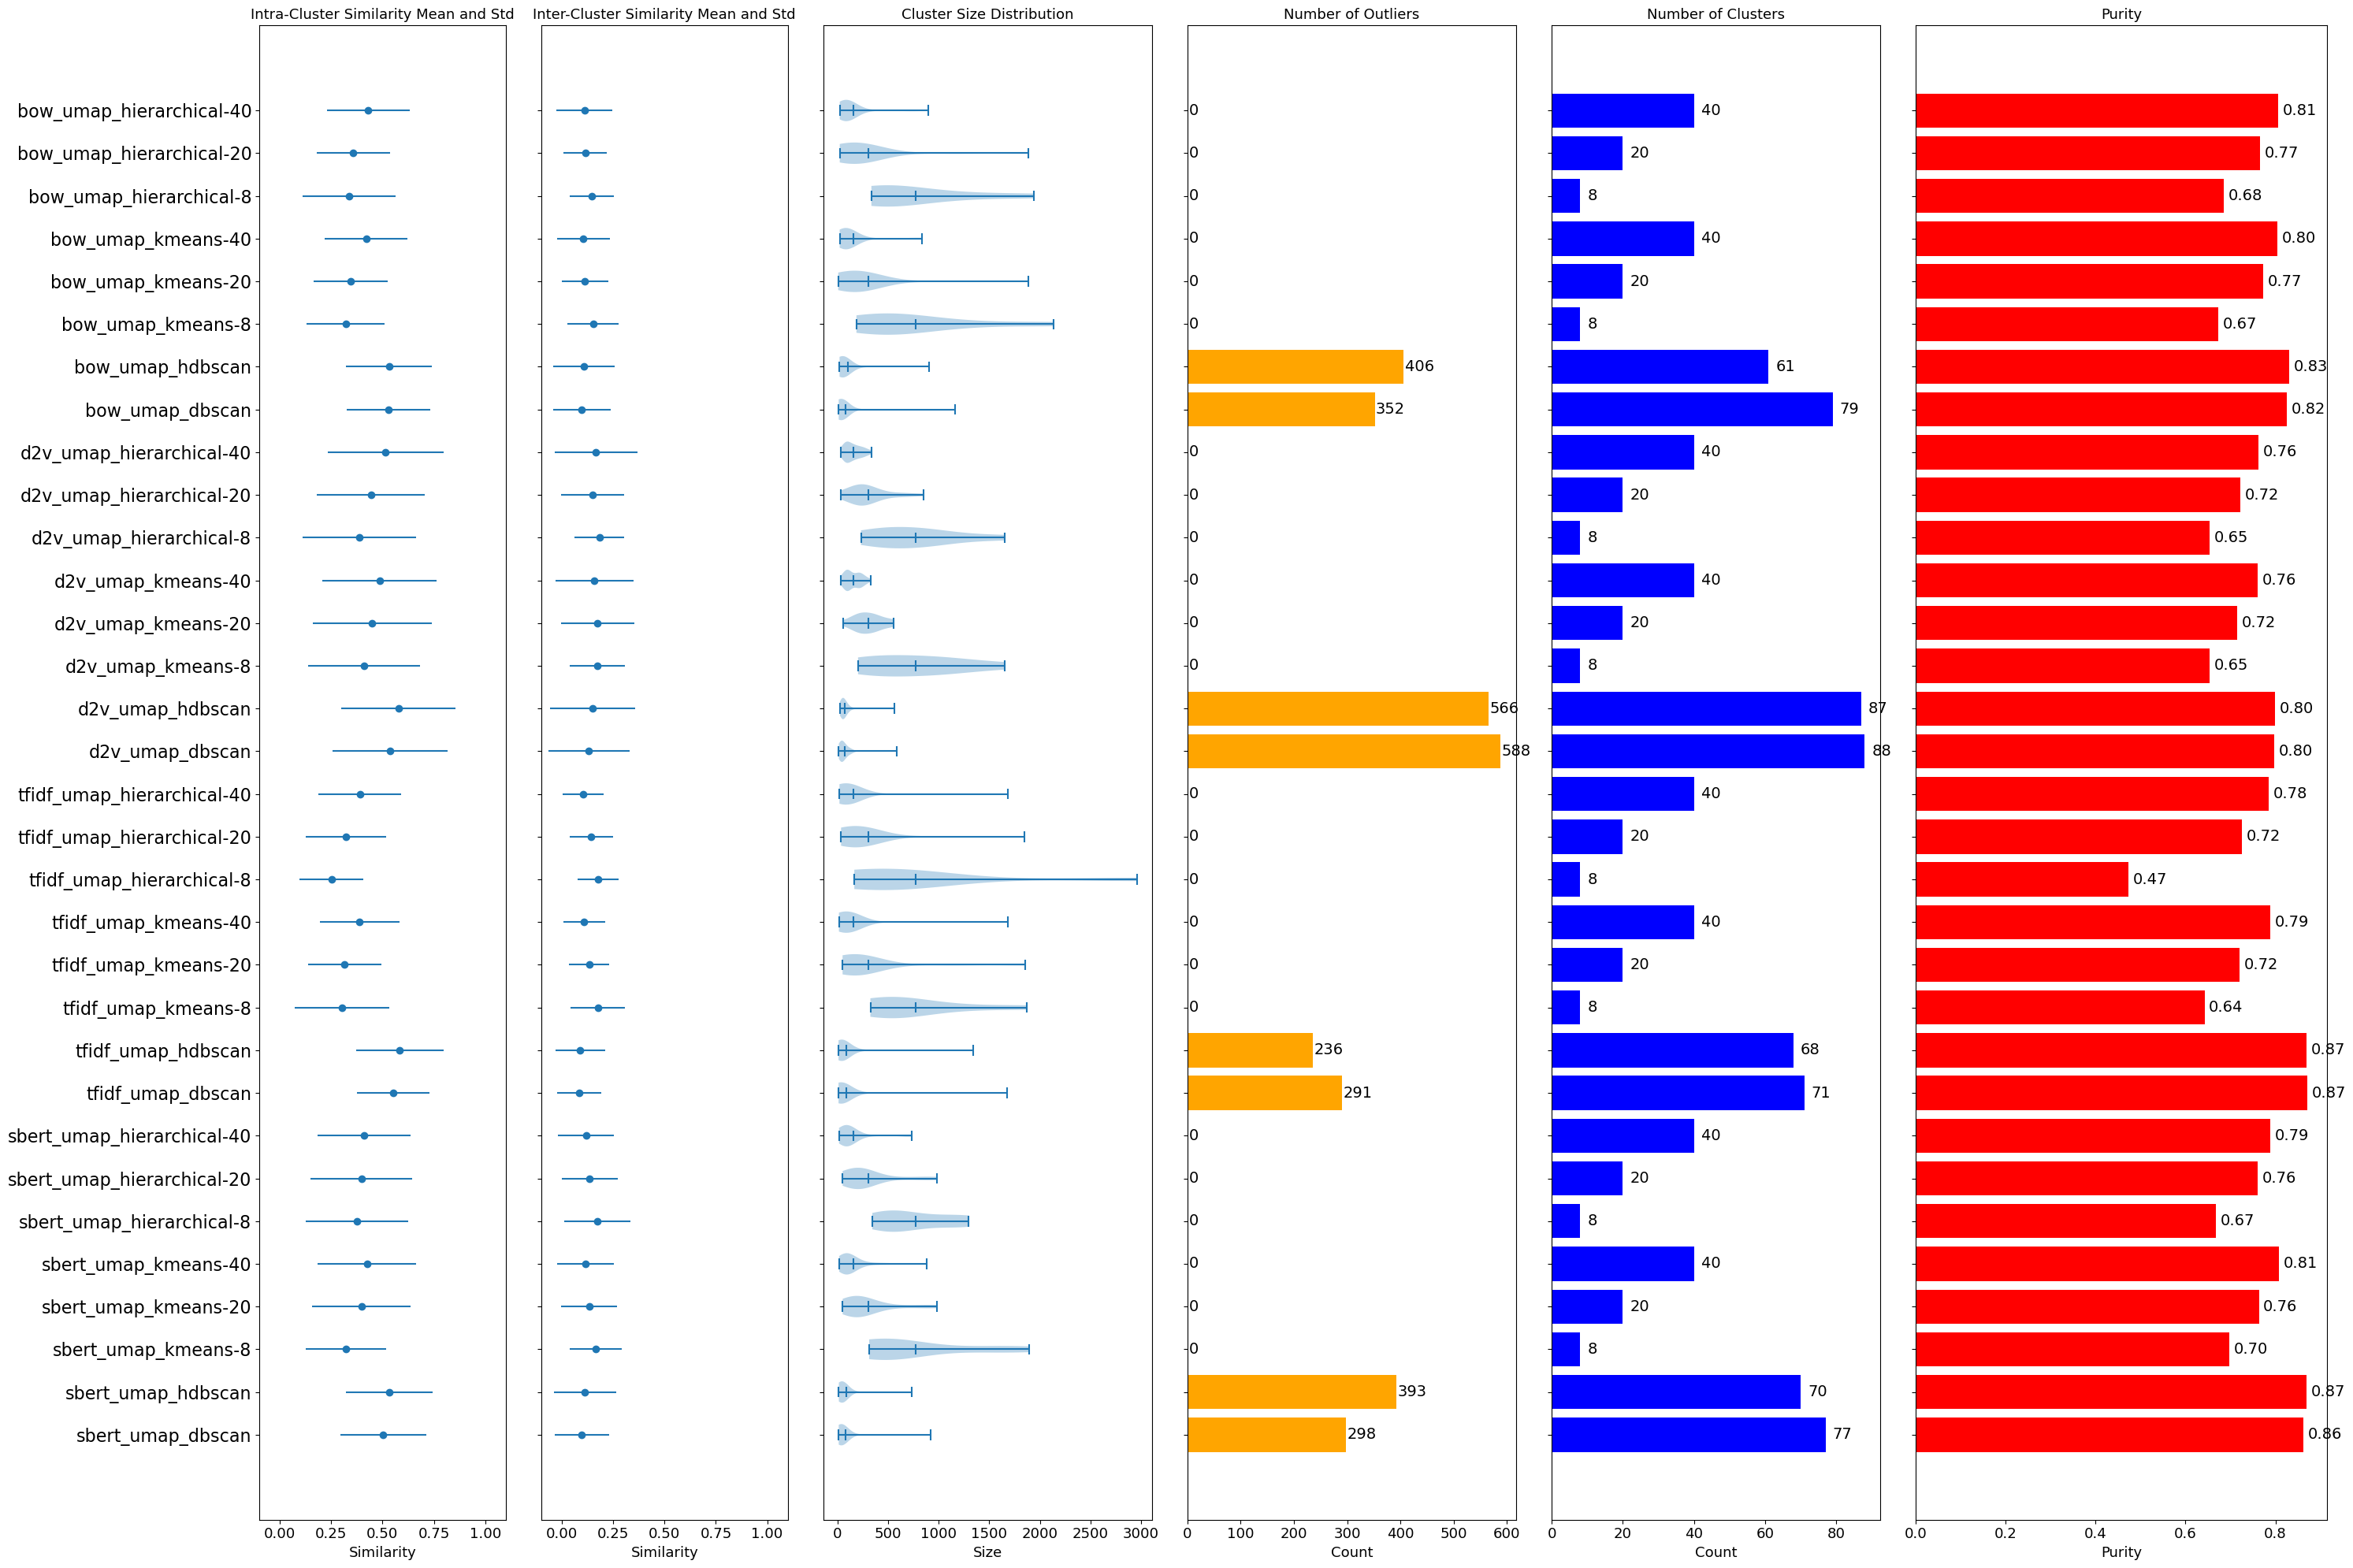

In [162]:
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['axes.titlesize'] = 13
mpl.rcParams['axes.labelsize'] = 13
fig, axes = plt.subplots(1, 6, figsize=(30, 20), gridspec_kw={'width_ratios': [0.75, 0.75, 1, 1, 1, 1.25]}, sharey=True)

# Ensure labels correspond to y-ticks across all plots
y_positions = range(len(labels))

# Panel 1: Intra-cluster similarity (mean & std)
axes[0].errorbar(
    y=y_positions,
    x=intra_stats[0],
    xerr=intra_stats[1],
    fmt='o'
)
axes[0].set_xlim(left = -0.1, right = 1.1)
axes[0].set_title("Intra-Cluster Similarity Mean and Std")
axes[0].set_xlabel("Similarity")
axes[0].set_yticks(y_positions)
axes[0].set_yticklabels(labels)

# Panel 2: Inter-cluster similarity (mean & std)
axes[1].errorbar(
    y=y_positions,
    x=inter_stats[0],
    xerr=inter_stats[1],
    fmt='o'
)
axes[1].set_xlim(left = -0.1, right = 1.1)
axes[1].set_title("Inter-Cluster Similarity Mean and Std")
axes[1].set_xlabel("Similarity")
axes[1].set_yticks(y_positions)
axes[1].set_yticklabels(labels)

# Panel 3: Cluster size distribution (violin plot)
axes[2].violinplot(cluster_dist, positions=y_positions, vert=False, showmeans=True)
axes[2].set_title("Cluster Size Distribution")
axes[2].set_xlabel("Size")
axes[2].set_yticks(y_positions)
axes[2].set_yticklabels(labels)

# Panel 4: Number of outliers
bars_outliers = axes[3].barh(y_positions, cluster_stats[0], color='orange')
axes[3].set_title("Number of Outliers")
axes[3].set_xlabel("Count")
axes[3].set_yticks(y_positions)
axes[3].set_yticklabels(labels)

for bar in bars_outliers:
    axes[3].text(
        bar.get_width() + 2,
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width())}',
        va='center',
        fontsize=14
    )

# Panel 5: Number of clusters
bars_clusters = axes[4].barh(y_positions, cluster_stats[1], color='blue')
axes[4].set_title("Number of Clusters")
axes[4].set_xlabel("Count")
axes[4].set_yticks(y_positions)
axes[4].set_yticklabels(labels)

# Add labels to bars (Panel 5)
for bar in bars_clusters:
    axes[4].text(
        bar.get_width() + 2,
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width())}',
        va='center',
        fontsize=14
    )

# Panel 6: Purity
bars_clusters = axes[5].barh(y_positions, purity, color='red')
axes[5].set_title("Purity")
axes[5].set_xlabel("Purity")
axes[5].set_yticks(y_positions)
axes[5].set_yticklabels(labels)

# Add labels to bars (Panel 6)
for bar in bars_clusters:
    axes[5].text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}',
        va='center',
        fontsize=14
    )

plt.tight_layout()
plt.show()